In [0]:
#!pip install transformers
#!pip install ktrain

In [0]:
import numpy as np
import pandas as pd
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/Datasets/Janata_hackathon_02

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Datasets/Janata_hackathon_02


In [4]:
!ls

game_overview.csv  sample_submission.csv  test.csv  train.csv


In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
ov_df = pd.read_csv('game_overview.csv')

In [6]:
train_df.head(3)

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1


In [7]:
train_df['user_suggestion'].value_counts()

1    9968
0    7526
Name: user_suggestion, dtype: int64

In [8]:
train_df.isnull().sum(axis = 0)

review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64

In [9]:
train_df['year'].value_counts()

2018.0    4822
2016.0    4226
2017.0    3890
2015.0    2460
2014.0    1499
2013.0     340
2012.0      65
2011.0      14
Name: year, dtype: int64

In [0]:
train_df['year'] = train_df['year'].fillna(train_df['year'].mode()[0])

In [11]:
test_df.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


In [12]:
test_df.isnull().sum(axis = 0)

review_id       0
title           0
year           67
user_review     0
dtype: int64

In [13]:
test_df['year'].value_counts()

2016.0    2502
2017.0    2161
2015.0    1314
2018.0    1229
2014.0     522
2013.0     120
2012.0      75
2011.0      55
Name: year, dtype: int64

In [0]:
test_df['year'] = test_df['year'].fillna(test_df['year'].mode()[0])

In [0]:
#Cleaning tags
proc_text = []
for i in ov_df['tags']:
  tmp = ''
  for j in re.split(r'[;,\'\s]', i):
    if(j not in [ '[',']','' ]):
      tmp += j + ','
  proc_text.append(tmp)

ov_df['tags'] = proc_text

In [16]:
ov_df.head(3)

,title,developer,publisher,tags,overview
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"Horror,Free,to,Play,Cute,First-Person,Singlepl...",Can you survive 1000 rooms of cute terror? Or ...
1,Sakura Clicker,Winged Cloud,Winged Cloud,"Nudity,Anime,Free,to,Play,Mature,Sexual,Conten...",The latest entry in the Sakura series is more ...
2,WARMODE,WARTEAM,WARTEAM,"Early,Access,Free,to,Play,FPS,Multiplayer,Shoo...",Free to play shooter about the confrontation o...


In [0]:
#extracting data from tag
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X = vect.fit_transform(ov_df['tags'])
X = X.toarray()

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
X.shape

(64, 185)

In [0]:
count_vect_df = pd.DataFrame(X, columns=[ 'tag_'+str(i) for i in range(1,X.shape[1]+1) ])
ov_df = pd.concat([ov_df, count_vect_df], axis=1)

In [22]:
ov_df.head(3)

,title,developer,publisher,tags,overview,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,...,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"Horror,Free,to,Play,Cute,First-Person,Singlepl...",Can you survive 1000 rooms of cute terror? Or ...,-0.412532,-0.125988,-0.641689,0.000000,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,-0.125988,...,-0.125988,-0.258199,-0.689730,-0.125988,-0.258199,-0.649786,4.509250,0.854242,-0.291111,-0.321634,-0.27501,-0.333333,-0.125988,-0.221766,-1.044431,-0.125988,3.142983,-0.412532,-0.179605,-0.221766,-0.455573,-0.510606,-0.125988,0.125988,-0.125988,-0.291111,-0.179605,-0.40452,-0.191882,-0.179605,-0.125988,-0.321634,-0.125988,-0.125988,-0.179605,-0.179605,4.509250,-0.429452,-1.0,-0.321634
1,Sakura Clicker,Winged Cloud,Winged Cloud,"Nudity,Anime,Free,to,Play,Mature,Sexual,Conten...",The latest entry in the Sakura series is more ...,1.987655,-0.125988,-0.641689,-1.632993,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,-0.350438,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,1.133893,-0.40452,-0.125988,-0.125988,-0.170114,3.109126,-1.223451,-0.291111,-0.125988,...,-0.125988,3.872983,-0.689730,-0.125988,3.872983,-0.649786,-0.221766,0.854242,-0.291111,-0.321634,-0.27501,-0.333333,-0.125988,4.509250,-1.044431,-0.125988,-0.616847,-0.412532,-0.179605,-0.221766,-0.455573,-0.510606,-0.125988,0.125988,-0.125988,-0.291111,-0.179605,-0.40452,-0.191882,-0.179605,-0.125988,-0.321634,-0.125988,-0.125988,-0.179605,-0.179605,-0.221766,-0.429452,-1.0,-0.321634
2,WARMODE,WARTEAM,WARTEAM,"Early,Access,Free,to,Play,FPS,Multiplayer,Shoo...",Free to play shooter about the confrontation o...,-0.412532,-0.125988,2.291746,0.000000,0.66423,-0.125988,-0.291111,-0.529150,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,...,-0.125988,-0.258199,0.886796,-0.125988,-0.258199,-0.649786,-0.221766,0.854242,-0.291111,-0.321634,-0.27501,-0.333333,-0.125988,-0.221766,-1.044431,-0.125988,1.263068,-0.412532,-0.179605,-0.221766,-0.455573,-0.510606,-0.125988,0.125988,-0.125988,-0.291111,-0.179605,-0.40452,-0.191882,-0.179605,-0.125988,-0.321634,-0.125988,-0.125988,-0.179605,-0.179605,-0.221766,1.187308,0.6,3.109126


#Preprocessing the reviews

The preprocessing which I have done are : <br>
1.expanding words (like can't to could not) <br>
2.removing special charaacters <br>
3.removing common word like the,is,am,etc. (stopwords) <br>
4.lemmatization


In [23]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [0]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [0]:
#@title CONTRACTIONS

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [0]:
def chn_lower_case(df,col):
  df[col] = df[col].str.lower()
  return df

In [0]:
#Function to expand several words like ''can't, won't, etc.''
def expand_contractions(df, col, contraction_mapping=CONTRACTION_MAP):
    
    proc_text = []
    for text in df[col]:
      contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                        flags=re.IGNORECASE|re.DOTALL)
      def expand_match(contraction):
          match = contraction.group(0)
          first_char = match[0]
          expanded_contraction = contraction_mapping.get(match)\
                                  if contraction_mapping.get(match)\
                                  else contraction_mapping.get(match.lower())                       
          expanded_contraction = first_char+expanded_contraction[1:]
          return expanded_contraction
          
      expanded_text = contractions_pattern.sub(expand_match, text)
      expanded_text = re.sub("'", "", expanded_text)
      proc_text.append(expanded_text)
    df[col] = proc_text
    return df

In [0]:
#Function to remove non-alphanumericals
def remove_special_characters(df, col):
  proc_text = []
  for text in df[col]:
    pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    proc_text.append(text)
  df[col] = proc_text
  return df

In [0]:
#Function to remove the stopwords
def remove_stopwords(df, col):
  proc_text = []
  for text in df[col]:
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    proc_text.append(filtered_text)
  df[col] = proc_text
  return df

In [0]:
#Function to lemmantize the dataframe
def lemment(df, col):
  proc_text = []

  for text in df[col]:
    text = ' '.join([wnl.lemmatize(word) for word in text.split()])
    proc_text.append(text)
  df[col] = proc_text
  return df

In [0]:
#Processing the dataframe
def process_df(df_to_process, col):
  df = chn_lower_case(df_to_process, col)
  df = expand_contractions(df, col)
  df = remove_stopwords(df, col)
  df = remove_special_characters(df, col)
  df = lemment(df, col)
  return df

In [33]:
ov_df = process_df(ov_df,'overview')
ov_df.head(3)

,title,developer,publisher,tags,overview,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,...,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"Horror,Free,to,Play,Cute,First-Person,Singlepl...",survive room cute terror break cuteness start ...,-0.412532,-0.125988,-0.641689,0.000000,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,-0.125988,...,-0.125988,-0.258199,-0.689730,-0.125988,-0.258199,-0.649786,4.509250,0.854242,-0.291111,-0.321634,-0.27501,-0.333333,-0.125988,-0.221766,-1.044431,-0.125988,3.142983,-0.412532,-0.179605,-0.221766,-0.455573,-0.510606,-0.125988,0.125988,-0.125988,-0.291111,-0.179605,-0.40452,-0.191882,-0.179605,-0.125988,-0.321634,-0.125988,-0.125988,-0.179605,-0.179605,4.509250,-0.429452,-1.0,-0.321634
1,Sakura Clicker,Winged Cloud,Winged Cloud,"Nudity,Anime,Free,to,Play,Mature,Sexual,Conten...",latest entry sakura series action packed ever ...,1.987655,-0.125988,-0.641689,-1.632993,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,-0.350438,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,1.133893,-0.40452,-0.125988,-0.125988,-0.170114,3.109126,-1.223451,-0.291111,-0.125988,...,-0.125988,3.872983,-0.689730,-0.125988,3.872983,-0.649786,-0.221766,0.854242,-0.291111,-0.321634,-0.27501,-0.333333,-0.125988,4.509250,-1.044431,-0.125988,-0.616847,-0.412532,-0.179605,-0.221766,-0.455573,-0.510606,-0.125988,0.125988,-0.125988,-0.291111,-0.179605,-0.40452,-0.191882,-0.179605,-0.125988,-0.321634,-0.125988,-0.125988,-0.179605,-0.179605,-0.221766,-0.429452,-1.0,-0.321634
2,WARMODE,WARTEAM,WARTEAM,"Early,Access,Free,to,Play,FPS,Multiplayer,Shoo...",free play shooter confrontation two irreconcil...,-0.412532,-0.125988,2.291746,0.000000,0.66423,-0.125988,-0.291111,-0.529150,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,...,-0.125988,-0.258199,0.886796,-0.125988,-0.258199,-0.649786,-0.221766,0.854242,-0.291111,-0.321634,-0.27501,-0.333333,-0.125988,-0.221766,-1.044431,-0.125988,1.263068,-0.412532,-0.179605,-0.221766,-0.455573,-0.510606,-0.125988,0.125988,-0.125988,-0.291111,-0.179605,-0.40452,-0.191882,-0.179605,-0.125988,-0.321634,-0.125988,-0.125988,-0.179605,-0.179605,-0.221766,1.187308,0.6,3.109126


In [34]:
#Extracting features from overview
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X = vect.fit_transform(ov_df['overview'])
X = X.toarray()
X.shape

(64, 3339)

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [0]:
#pca = PCA(n_components=64)
#X = pca.fit_transform(X)

In [0]:
count_vect_df = pd.DataFrame(X, columns=[ 'ov_'+str(i) for i in range(1,X.shape[1]+1) ])
ov_df = pd.concat([ov_df, count_vect_df], axis=1)

In [0]:
to_drop = ['publisher', 'tags', 'overview']
ov_df = ov_df.drop(to_drop, axis=1)

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ov_df['developer'] = le.fit_transform(ov_df['developer'])
ov_df.head(3)

,title,developer,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,...,ov_3300,ov_3301,ov_3302,ov_3303,ov_3304,ov_3305,ov_3306,ov_3307,ov_3308,ov_3309,ov_3310,ov_3311,ov_3312,ov_3313,ov_3314,ov_3315,ov_3316,ov_3317,ov_3318,ov_3319,ov_3320,ov_3321,ov_3322,ov_3323,ov_3324,ov_3325,ov_3326,ov_3327,ov_3328,ov_3329,ov_3330,ov_3331,ov_3332,ov_3333,ov_3334,ov_3335,ov_3336,ov_3337,ov_3338,ov_3339
0,Spooky's Jump Scare Mansion,32,-0.412532,-0.125988,-0.641689,0.000000,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,-0.125988,-0.455573,-0.258199,-0.321634,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
1,Sakura Clicker,57,1.987655,-0.125988,-0.641689,-1.632993,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,-0.350438,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,1.133893,-0.40452,-0.125988,-0.125988,-0.170114,3.109126,-1.223451,-0.291111,-0.125988,-0.455573,3.872983,-0.321634,...,-0.125988,-0.333333,-0.291111,-0.316621,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988
2,WARMODE,54,-0.412532,-0.125988,2.291746,0.000000,0.66423,-0.125988,-0.291111,-0.529150,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,-0.455573,-0.258199,3.109126,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988


In [0]:
train_df = pd.merge(train_df, ov_df, how='left', on=['title'])

In [41]:
train_df.head(3)

,review_id,title,year,user_review,user_suggestion,developer,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,...,ov_3300,ov_3301,ov_3302,ov_3303,ov_3304,ov_3305,ov_3306,ov_3307,ov_3308,ov_3309,ov_3310,ov_3311,ov_3312,ov_3313,ov_3314,ov_3315,ov_3316,ov_3317,ov_3318,ov_3319,ov_3320,ov_3321,ov_3322,ov_3323,ov_3324,ov_3325,ov_3326,ov_3327,ov_3328,ov_3329,ov_3330,ov_3331,ov_3332,ov_3333,ov_3334,ov_3335,ov_3336,ov_3337,ov_3338,ov_3339
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1,32,-0.412532,-0.125988,-0.641689,0.0,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1,32,-0.412532,-0.125988,-0.641689,0.0,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1,32,-0.412532,-0.125988,-0.641689,0.0,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988


In [0]:
test_df = pd.merge(test_df, ov_df, how='left', on=['title'])

In [43]:
test_df.head(3)

,review_id,title,year,user_review,developer,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,...,ov_3300,ov_3301,ov_3302,ov_3303,ov_3304,ov_3305,ov_3306,ov_3307,ov_3308,ov_3309,ov_3310,ov_3311,ov_3312,ov_3313,ov_3314,ov_3315,ov_3316,ov_3317,ov_3318,ov_3319,ov_3320,ov_3321,ov_3322,ov_3323,ov_3324,ov_3325,ov_3326,ov_3327,ov_3328,ov_3329,ov_3330,ov_3331,ov_3332,ov_3333,ov_3334,ov_3335,ov_3336,ov_3337,ov_3338,ov_3339
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B...",53,-0.412532,-0.125988,-0.641689,0.0,-1.184062,-0.125988,-0.291111,-0.52915,-0.125988,-0.221766,-0.350438,-0.221766,1.256624,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,...,-0.125988,-0.333333,-0.291111,0.143918,-0.125988,-0.125988,-0.125988,2.645751,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,5.980465,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...,53,-0.412532,-0.125988,-0.641689,0.0,-1.184062,-0.125988,-0.291111,-0.52915,-0.125988,-0.221766,-0.350438,-0.221766,1.256624,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,...,-0.125988,-0.333333,-0.291111,0.143918,-0.125988,-0.125988,-0.125988,2.645751,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,5.980465,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...,53,-0.412532,-0.125988,-0.641689,0.0,-1.184062,-0.125988,-0.291111,-0.52915,-0.125988,-0.221766,-0.350438,-0.221766,1.256624,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,...,-0.125988,-0.333333,-0.291111,0.143918,-0.125988,-0.125988,-0.125988,2.645751,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,5.980465,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988


In [44]:
train_df = process_df(train_df,'user_review')
train_df.head(3)

,review_id,title,year,user_review,user_suggestion,developer,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,...,ov_3300,ov_3301,ov_3302,ov_3303,ov_3304,ov_3305,ov_3306,ov_3307,ov_3308,ov_3309,ov_3310,ov_3311,ov_3312,ov_3313,ov_3314,ov_3315,ov_3316,ov_3317,ov_3318,ov_3319,ov_3320,ov_3321,ov_3322,ov_3323,ov_3324,ov_3325,ov_3326,ov_3327,ov_3328,ov_3329,ov_3330,ov_3331,ov_3332,ov_3333,ov_3334,ov_3335,ov_3336,ov_3337,ov_3338,ov_3339
0,1,Spooky's Jump Scare Mansion,2016.0,scared hearing creepy voice pause moment write...,1,32,-0.412532,-0.125988,-0.641689,0.0,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
1,2,Spooky's Jump Scare Mansion,2016.0,best game better sam pepper youtube account wh...,1,32,-0.412532,-0.125988,-0.641689,0.0,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
2,3,Spooky's Jump Scare Mansion,2016.0,littly iffy control know play easy master made...,1,32,-0.412532,-0.125988,-0.641689,0.0,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988


In [45]:
test_df = process_df(test_df,'user_review')
test_df.head(3)

,review_id,title,year,user_review,developer,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,...,ov_3300,ov_3301,ov_3302,ov_3303,ov_3304,ov_3305,ov_3306,ov_3307,ov_3308,ov_3309,ov_3310,ov_3311,ov_3312,ov_3313,ov_3314,ov_3315,ov_3316,ov_3317,ov_3318,ov_3319,ov_3320,ov_3321,ov_3322,ov_3323,ov_3324,ov_3325,ov_3326,ov_3327,ov_3328,ov_3329,ov_3330,ov_3331,ov_3332,ov_3333,ov_3334,ov_3335,ov_3336,ov_3337,ov_3338,ov_3339
0,1603,Counter-Strike: Global Offensive,2015.0,nice graphic new map weapon model developer li...,53,-0.412532,-0.125988,-0.641689,0.0,-1.184062,-0.125988,-0.291111,-0.52915,-0.125988,-0.221766,-0.350438,-0.221766,1.256624,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,...,-0.125988,-0.333333,-0.291111,0.143918,-0.125988,-0.125988,-0.125988,2.645751,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,5.980465,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
1,1604,Counter-Strike: Global Offensive,2018.0,would not recommend getting current state csgo...,53,-0.412532,-0.125988,-0.641689,0.0,-1.184062,-0.125988,-0.291111,-0.52915,-0.125988,-0.221766,-0.350438,-0.221766,1.256624,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,...,-0.125988,-0.333333,-0.291111,0.143918,-0.125988,-0.125988,-0.125988,2.645751,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,5.980465,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
2,1605,Counter-Strike: Global Offensive,2018.0,edit i tried playing c go recently dramaticall...,53,-0.412532,-0.125988,-0.641689,0.0,-1.184062,-0.125988,-0.291111,-0.52915,-0.125988,-0.221766,-0.350438,-0.221766,1.256624,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,...,-0.125988,-0.333333,-0.291111,0.143918,-0.125988,-0.125988,-0.125988,2.645751,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,5.980465,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988


In [0]:
tid = test_df['review_id']
Y = train_df['user_suggestion']
to_drop = ['title', 'review_id']
train_df = train_df.drop(to_drop,axis=1)
train_df = train_df.drop(['user_suggestion'],axis=1)
test_df = test_df.drop(to_drop,axis=1)

In [47]:
train_df.head(3)

,year,user_review,developer,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,...,ov_3300,ov_3301,ov_3302,ov_3303,ov_3304,ov_3305,ov_3306,ov_3307,ov_3308,ov_3309,ov_3310,ov_3311,ov_3312,ov_3313,ov_3314,ov_3315,ov_3316,ov_3317,ov_3318,ov_3319,ov_3320,ov_3321,ov_3322,ov_3323,ov_3324,ov_3325,ov_3326,ov_3327,ov_3328,ov_3329,ov_3330,ov_3331,ov_3332,ov_3333,ov_3334,ov_3335,ov_3336,ov_3337,ov_3338,ov_3339
0,2016.0,scared hearing creepy voice pause moment write...,32,-0.412532,-0.125988,-0.641689,0.0,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,-0.125988,-0.455573,-0.258199,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
1,2016.0,best game better sam pepper youtube account wh...,32,-0.412532,-0.125988,-0.641689,0.0,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,-0.125988,-0.455573,-0.258199,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
2,2016.0,littly iffy control know play easy master made...,32,-0.412532,-0.125988,-0.641689,0.0,0.66423,-0.125988,-0.291111,1.889822,-0.125988,-0.221766,2.853569,-0.221766,-0.491723,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,-1.223451,3.435113,-0.125988,-0.455573,-0.258199,...,-0.125988,-0.333333,-0.291111,-0.777159,-0.125988,-0.125988,-0.125988,-0.377964,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,7.937254,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,-0.243108,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988


In [48]:
test_df.head(3)

,year,user_review,developer,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,...,ov_3300,ov_3301,ov_3302,ov_3303,ov_3304,ov_3305,ov_3306,ov_3307,ov_3308,ov_3309,ov_3310,ov_3311,ov_3312,ov_3313,ov_3314,ov_3315,ov_3316,ov_3317,ov_3318,ov_3319,ov_3320,ov_3321,ov_3322,ov_3323,ov_3324,ov_3325,ov_3326,ov_3327,ov_3328,ov_3329,ov_3330,ov_3331,ov_3332,ov_3333,ov_3334,ov_3335,ov_3336,ov_3337,ov_3338,ov_3339
0,2015.0,nice graphic new map weapon model developer li...,53,-0.412532,-0.125988,-0.641689,0.0,-1.184062,-0.125988,-0.291111,-0.52915,-0.125988,-0.221766,-0.350438,-0.221766,1.256624,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,2.195036,-0.258199,...,-0.125988,-0.333333,-0.291111,0.143918,-0.125988,-0.125988,-0.125988,2.645751,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,5.980465,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
1,2018.0,would not recommend getting current state csgo...,53,-0.412532,-0.125988,-0.641689,0.0,-1.184062,-0.125988,-0.291111,-0.52915,-0.125988,-0.221766,-0.350438,-0.221766,1.256624,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,2.195036,-0.258199,...,-0.125988,-0.333333,-0.291111,0.143918,-0.125988,-0.125988,-0.125988,2.645751,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,5.980465,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988
2,2018.0,edit i tried playing c go recently dramaticall...,53,-0.412532,-0.125988,-0.641689,0.0,-1.184062,-0.125988,-0.291111,-0.52915,-0.125988,-0.221766,-0.350438,-0.221766,1.256624,-0.125988,-0.258199,-0.179605,-0.125988,-0.221766,-0.125988,-0.125988,-0.386912,-0.125988,-0.125988,-0.365397,-0.125988,-0.125988,-0.881917,-0.40452,-0.125988,-0.125988,-0.170114,-0.321634,1.113888,-0.291111,-0.125988,2.195036,-0.258199,...,-0.125988,-0.333333,-0.291111,0.143918,-0.125988,-0.125988,-0.125988,2.645751,-0.125988,-0.179605,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.179605,-0.125988,-0.160128,-0.179605,-0.170114,-0.125988,-0.221766,-0.125988,-0.125988,5.980465,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988,-0.125988


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
#Extracting features from the preprocessed user review
cv=TfidfVectorizer()
X = cv.fit_transform(train_df['user_review'])
X_val = cv.transform(test_df['user_review'])

In [51]:
X = X.toarray()
X_val = X_val.toarray()
print(X.shape)
X_val.shape

(17494, 44965)


(8045, 44965)

In [52]:
ur_train = pd.DataFrame({'ur':train_df['user_review']})
ur_test = pd.DataFrame({'ur':test_df['user_review']})
train_df = train_df.drop( ['user_review'] , axis=1)
test_df = test_df.drop( ['user_review'] , axis=1)
X_ov = train_df.values
Xt_ov = test_df.values
print(X_ov.shape)
Xt_ov.shape

(17494, 3526)


(8045, 3526)

In [0]:
ur_train['ur'] = ur_train['ur'].apply(lambda x: x+' ')
ur_test['ur'] = ur_test['ur'].apply(lambda x: x+' ')
lab = pd.DataFrame({'l':Y})

In [54]:
%cd ..
%cd ..
%cd ..
%cd ..
!ls

/content/drive/My Drive/Datasets
/content/drive/My Drive
/content/drive
/content
drive  sample_data


#Training

Here, I have trained the model only using the features extracted from the cleaned user reviews, adding features from overview file or representing the sentences using word2vec didn't improve accuracy.


## Training 1.0
Training models using features extracted from TF-ID vectorizer.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split

In [66]:
#array X contains features from TF-ID vectoriser
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.2,random_state=0)
print(X_train.shape)
print(X_test.shape)

(13995, 44965)
(3499, 44965)


In [0]:
#Fitting logistic regression model to the data
lr=LogisticRegression(max_iter=200)
lr.fit(X_train,y_train)
pred=lr.predict(X_test)

In [0]:
from sklearn.metrics import classification_report

In [69]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1506
           1       0.85      0.90      0.87      1993

    accuracy                           0.85      3499
   macro avg       0.85      0.85      0.85      3499
weighted avg       0.85      0.85      0.85      3499



In [87]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[1196,  310],
       [ 204, 1789]])

In [0]:
y_val = lr.predict(X_val)
sub = pd.DataFrame({'review_id':tid, 'user_suggestion':y_val})
sub.to_csv('predictions.csv',index=False)

## Training 2.0
Here, I have used a transfer learning from a pre-trained DistilRoBERTa (light-wight compared to RoBERTa) model. <br>
I have used *ktrain* library to load and train the distilroberta model.

In [0]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import ktrain
from ktrain import text

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(ur_train['ur'].values, lab['l'].values, test_size = 0.2, random_state=0)

In [0]:
MODEL_NAME = 'distilroberta-base'

In [83]:
t = text.Transformer(MODEL_NAME, maxlen = 220, class_names = [0, 1])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_train(x_valid, y_valid)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 8 )

preprocessing train...
language: en
train sequence lengths:
	mean : 73
	95percentile : 227
	99percentile : 453


preprocessing train...
language: en
train sequence lengths:
	mean : 75
	95percentile : 241
	99percentile : 450


simulating training for different learning rates... this may take a few moments...
Train for 1749 steps
1148/1749 [==================>...........] - ETA: 1:27 - loss: 0.7590 - accuracy: 0.6272

done.
Visually inspect loss plot and select learning rate associated with falling loss


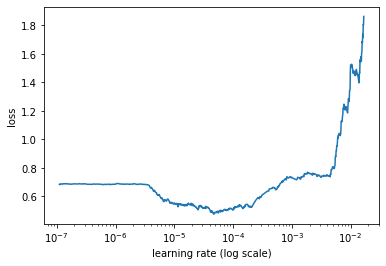

In [84]:
learner.lr_find(show_plot = True, max_epochs = 1)

In [85]:
learner.fit_onecycle(4e-5, 3)



begin training using onecycle policy with max lr of 4e-05...
Train for 1750 steps, validate for 110 steps
Epoch 1/3
1750/1750 [==============================] - 261s 149ms/step - loss: 0.4503 - accuracy: 0.7774 - val_loss: 0.3117 - val_accuracy: 0.8691
Epoch 2/3
1750/1750 [==============================] - 254s 145ms/step - loss: 0.3031 - accuracy: 0.8737 - val_loss: 0.2947 - val_accuracy: 0.8760
Epoch 3/3
1750/1750 [==============================] - 255s 146ms/step - loss: 0.1719 - accuracy: 0.9349 - val_loss: 0.3261 - val_accuracy: 0.8811


In [86]:
learner.validate(class_names = t.get_classes())

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1506
           1       0.89      0.90      0.90      1993

    accuracy                           0.88      3499
   macro avg       0.88      0.88      0.88      3499
weighted avg       0.88      0.88      0.88      3499



array([[1291,  215],
       [ 201, 1792]])